In [1]:
import random
import pandas as pd
import numpy as np
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from pandas import Series, DataFrame

C:\Users\User\Pictures\ANACONDA\envs\tensorflow\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [3]:
train_df = pd.read_csv('C:/Users/김승우/Desktop/파이썬/train.csv')
train_df = train_df.drop(columns=['ID'])
val_df = pd.read_csv('C:/Users/김승우/Desktop/파이썬/val.csv')
val_df = val_df.drop(columns=['ID'])
val_re=val_df.drop(columns=['Class'])

In [4]:
val_df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,V29,V30,Class
0,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,-0.366846,...,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,-0.255991,-0.994878,0
1,0.962496,0.328461,-0.171479,2.109204,1.129566,1.696038,0.107712,0.521502,-1.191311,0.724396,...,0.402492,-0.048508,-1.371866,0.390814,0.199964,0.016371,-0.014605,0.168937,-0.994784,0
2,1.145524,0.575068,0.194008,2.598192,-0.092210,-1.044430,0.531588,-0.241888,-0.896287,0.757952,...,-0.119703,-0.076510,0.691320,0.633984,0.048741,-0.053192,0.016251,0.169496,-0.994502,0
3,0.927060,-0.323684,0.387585,0.544474,0.246787,1.650358,-0.427576,0.615371,0.226278,-0.225495,...,0.079359,0.096632,-0.992569,0.085096,0.377447,0.036096,-0.005960,0.331307,-0.994467,0
4,-3.005237,2.600138,1.483691,-2.418473,0.306326,-0.824575,2.065426,-1.829347,4.009259,6.051521,...,-0.181268,-0.163747,0.515821,0.136318,0.460054,-0.251259,-1.105751,-0.287012,-0.994373,0


In [5]:
val_fraud=val_df[val_df["Class"]==1]
print(val_fraud)
index=val_fraud.index.to_list()
print("\n Index info")
print(index)

              V1         V2         V3         V4         V5        V6  \
71     -3.043541  -3.157307   1.088463   2.288644   1.359805 -1.064823   
641     0.316459   3.809076  -5.615159   6.047445   1.554026 -2.651353   
677     0.857321   4.093912  -7.423894   7.380245   0.973366 -2.730762   
836    -1.426623   4.141986  -9.804103   6.666273  -4.749527 -2.073129   
1196  -16.367923   9.223692 -23.270631  11.844777  -9.462037 -2.450444   
1201  -16.917468   9.669900 -23.736443  11.824990  -9.830548 -2.514829   
1547  -18.474868  11.586381 -21.402917   6.038515 -14.451158 -4.146524   
3055   -3.896583   4.518355  -4.454027   5.547453  -4.121459 -1.163407   
4039    1.159373   2.844795  -4.050680   4.777701   2.948980 -2.010361   
4267  -13.897206   6.344280 -14.281666   5.581009 -12.887133 -3.146176   
4396  -19.139733   9.286847 -20.134992   7.818673 -15.652208 -1.668348   
7702   -2.335655   2.225380  -3.379450   2.178538  -3.568264  0.316814   
9326    1.080433   0.962831  -0.278065

In [6]:
import pandas as pd
import numpy as np

def mean_norm(df_input):
    return df_input.apply(lambda x: (x-x.mean())/ x.std(), axis=0)

val_df_ss = mean_norm(val_df)
print(val_df_ss)

             V1        V2        V3        V4        V5        V6        V7  \
0     -0.177780  0.696225  0.695418 -0.159472  0.376984 -0.177240  0.554467   
1      0.495965  0.203369 -0.115281  1.499718  0.848996  1.326225  0.087678   
2      0.590767  0.356999  0.128418  1.847717 -0.066091 -0.794527  0.451478   
3      0.477610 -0.202902  0.257491  0.386141  0.187812  1.290875 -0.371745   
4     -1.559174  1.618569  0.988350 -1.722510  0.232405 -0.624389  1.767928   
...         ...       ...       ...       ...       ...       ...       ...   
28457 -0.285576  0.892088 -0.209812  0.657694  0.394232 -0.424031  0.910213   
28458 -0.398567  0.365291 -0.606110 -0.299429  0.678200 -0.575038  0.646269   
28459 -0.234077  0.809992 -0.113350  0.697216  0.436601 -0.454964  1.071016   
28460  1.053844 -0.110421 -0.798960  0.165597 -0.003554 -0.548548  0.009865   
28461 -0.127112  0.329223  0.467476  0.489565 -0.280113  0.496386 -0.593697   

             V8        V9       V10  ...       V22 

In [7]:
val_df_ss_fraud=val_df_ss.loc[index]
print(val_df_ss_fraud)

              V1         V2         V3        V4         V5        V6  \
71     -1.579014  -1.968181   0.724821  1.627420   1.021441 -0.810309   
641     0.161341   2.371708  -3.745009  4.302460   1.166909 -2.038070   
677     0.441488   2.549154  -4.951034  5.250978   0.732005 -2.099521   
836    -0.741511   2.579103  -6.538107  4.742863  -3.554333 -1.590602   
1196   -8.480551   5.744884 -15.517296  8.428267  -7.083914 -1.882594   
1201   -8.765195   6.022861 -15.827890  8.414186  -7.359922 -1.932419   
1547   -9.571870   7.216782 -14.271945  4.296105 -10.820672 -3.195130   
3055   -2.020858   2.813572  -2.970792  3.946629  -3.083922 -0.886600   
4039    0.597940   1.770984  -2.701848  3.398816   2.211703 -1.542028   
4267   -7.200811   3.951080  -9.523649  3.970510  -9.649247 -2.420996   
4396   -9.916246   5.784228 -13.426520  5.562996 -11.720235 -1.277356   
7702   -1.212355   1.385103  -2.254287  1.549061  -2.669590  0.258891   
9326    0.557052   0.598566  -0.186351  1.951000   

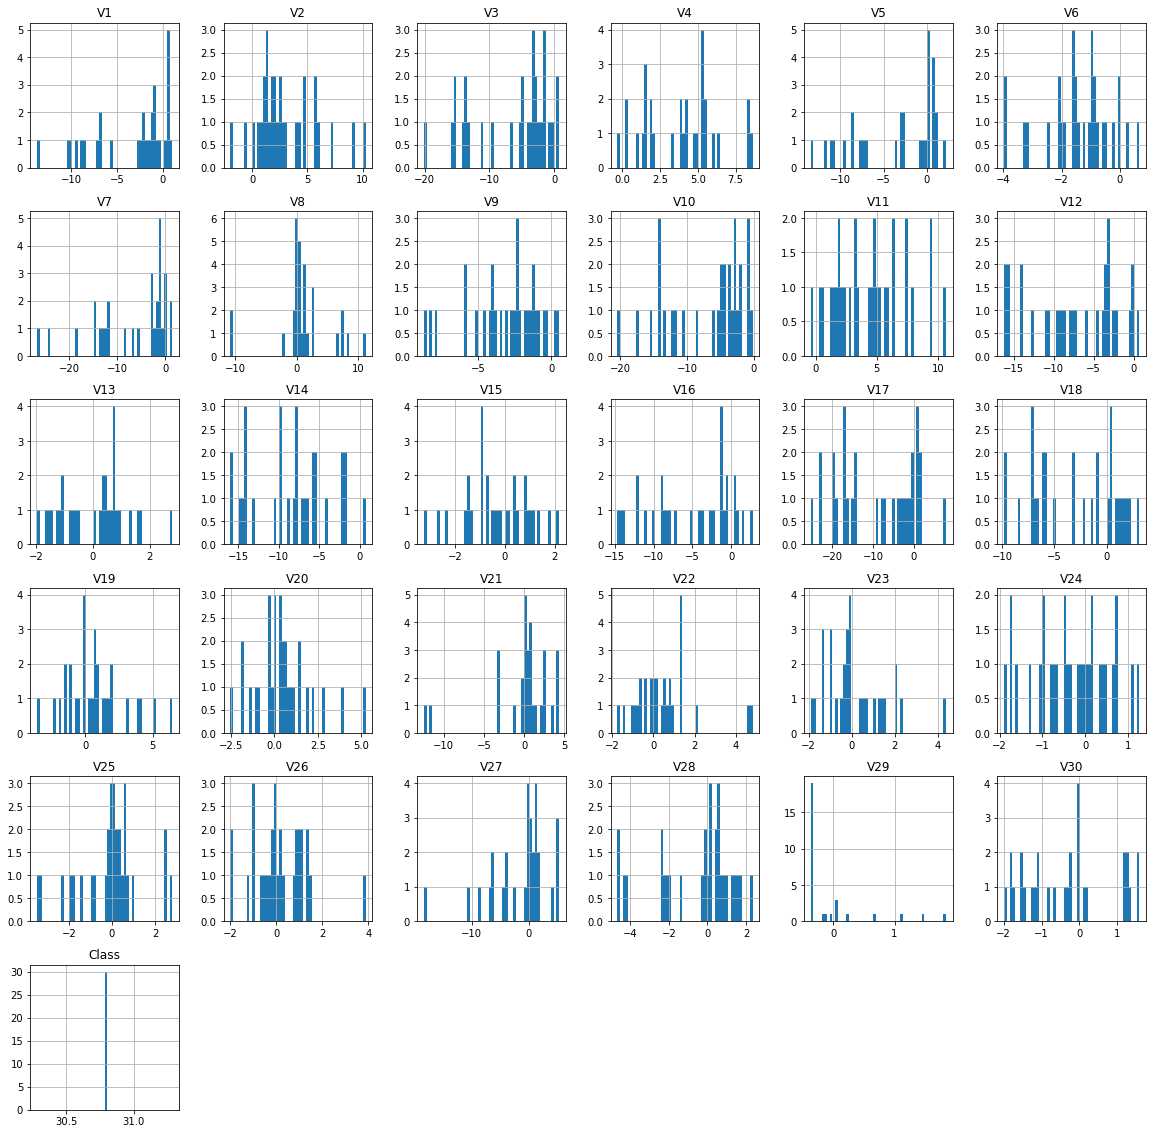

In [8]:
val_df_ss_fraud.hist(bins = 50, figsize = (20,20))
plt.show()

In [9]:
val_df_ss_fraud=val_df_ss_fraud**2

In [10]:
val_df_ss_fraud.sum()

V1         837.261995
V2         486.825038
V3        2318.483142
V4         627.950347
V5        1020.893449
V6          96.866704
V7        3031.531722
V8         610.439513
V9         445.115537
V10       2440.117488
V11        817.454015
V12       2449.949704
V13         37.993958
V14       2715.521810
V15         51.495540
V16       1623.472952
V17       4887.567869
V18        720.152848
V19        158.207126
V20         85.070018
V21        427.996096
V22         69.728692
V23         56.806406
V24         24.073152
V25         62.262633
V26         41.461606
V27        811.313837
V28        124.140565
V29          9.806658
V30         40.175201
Class    28431.001054
dtype: float64

In [11]:
sorted(val_df_ss_fraud.sum())

[9.806657908956652,
 24.073151737699312,
 37.993958419264885,
 40.175200850084224,
 41.46160598083588,
 51.49553983617563,
 56.80640553985462,
 62.2626332032695,
 69.72869247989271,
 85.07001807067404,
 96.86670436071982,
 124.14056468836304,
 158.20712573665688,
 427.99609637521104,
 445.11553683804664,
 486.82503755692227,
 610.4395131588745,
 627.9503473757957,
 720.1528484401858,
 811.3138371311712,
 817.4540153302598,
 837.261995104475,
 1020.8934492047263,
 1623.472951511356,
 2318.4831419365223,
 2440.117487776556,
 2449.9497041083823,
 2715.5218098631312,
 3031.531721678624,
 4887.567869194054,
 28431.001054031454]

In [12]:
train_1=train_df.drop(columns=["V7","V14","V12","V10","V3","V16","V5","V1","V27","V11","V18","V4","V8","V2","V9","V21","V19","V28","V6","V20","V22","V25","V23","V15","V26","V30","V13","V24","V29"])
train_2=train_df.drop(columns=["V14","V12","V10","V3","V16","V5","V1","V27","V11","V18","V4","V8","V2","V9","V21","V19","V28","V6","V20","V22","V25","V23","V15","V26","V30","V13","V24","V29"])
train_3=train_df.drop(columns=["V12","V10","V3","V16","V5","V1","V27","V11","V18","V4","V8","V2","V9","V21","V19","V28","V6","V20","V22","V25","V23","V15","V26","V30","V13","V24","V29"])
train_4=train_df.drop(columns=["V10","V3","V16","V5","V1","V27","V11","V18","V4","V8","V2","V9","V21","V19","V28","V6","V20","V22","V25","V23","V15","V26","V30","V13","V24","V29"])
train_5=train_df.drop(columns=["V3","V16","V5","V1","V27","V11","V18","V4","V8","V2","V9","V21","V19","V28","V6","V20","V22","V25","V23","V15","V26","V30","V13","V24","V29"])
train_6=train_df.drop(columns=["V16","V5","V1","V27","V11","V18","V4","V8","V2","V9","V21","V19","V28","V6","V20","V22","V25","V23","V15","V26","V30","V13","V24","V29"])
train_7=train_df.drop(columns=["V5","V1","V27","V11","V18","V4","V8","V2","V9","V21","V19","V28","V6","V20","V22","V25","V23","V15","V26","V30","V13","V24","V29"])
train_8=train_df.drop(columns=["V1","V27","V11","V18","V4","V8","V2","V9","V21","V19","V28","V6","V20","V22","V25","V23","V15","V26","V30","V13","V24","V29"])
train_9=train_df.drop(columns=["V27","V11","V18","V4","V8","V2","V9","V21","V19","V28","V6","V20","V22","V25","V23","V15","V26","V30","V13","V24","V29"])
train_10=train_df.drop(columns=["V11","V18","V4","V8","V2","V9","V21","V19","V28","V6","V20","V22","V25","V23","V15","V26","V30","V13","V24","V29"])
train_11=train_df.drop(columns=["V4","V8","V2","V9","V21","V19","V28","V6","V20","V22","V25","V23","V15","V26","V30","V13","V24","V29"])
train_12=train_df.drop(columns=["V8","V2","V9","V21","V19","V28","V6","V20","V22","V25","V23","V15","V26","V30","V13","V24","V29"])
train_13=train_df.drop(columns=["V2","V9","V21","V19","V28","V6","V20","V22","V25","V23","V15","V26","V30","V13","V24","V29"])
train_14=train_df.drop(columns=["V9","V21","V19","V28","V6","V20","V22","V25","V23","V15","V26","V30","V13","V24","V29"])
train_15=train_df.drop(columns=["V21","V19","V28","V6","V20","V22","V25","V23","V15","V26","V30","V13","V24","V29"])
train_16=train_df.drop(columns=["V19","V28","V6","V20","V22","V25","V23","V15","V26","V30","V13","V24","V29"])
train_17=train_df.drop(columns=["V28","V6","V20","V22","V25","V23","V15","V26","V30","V13","V24","V29"])
train_18=train_df.drop(columns=["V6","V20","V22","V25","V23","V15","V26","V30","V13","V24","V29"])
train_19=train_df.drop(columns=["V20","V22","V25","V23","V15","V26","V30","V13","V24","V29"])
train_20=train_df.drop(columns=["V22","V25","V23","V15","V26","V30","V13","V24","V29"])
train_21=train_df.drop(columns=["V25","V23","V15","V26","V30","V13","V24","V29"])
train_22=train_df.drop(columns=["V23","V15","V26","V30","V13","V24","V29"])
train_23=train_df.drop(columns=["V15","V26","V30","V13","V24","V29"])
train_24=train_df.drop(columns=["V26","V30","V13","V24","V29"])
train_25=train_df.drop(columns=["V30","V13","V24","V29"])
train_26=train_df.drop(columns=["V13","V24","V29"])
train_27=train_df.drop(columns=["V24","V29"])
train_28=train_df.drop(columns=["V29"])



In [13]:
train_2

,V7,V17
0,0.791461,1.109969
1,0.237609,-0.684093
2,0.476201,-0.058133
3,1.120631,-1.222127
4,0.370145,-0.499768
...,...,...
113837,-3.632516,0.586179
113838,0.190241,-0.199950
113839,0.929369,-0.174846
113840,0.812722,0.070441


In [14]:
val_1=val_df.drop(columns=["V7","V14","V12","V10","V3","V16","V5","V1","V27","V11","V18","V4","V8","V2","V9","V21","V19","V28","V6","V20","V22","V25","V23","V15","V26","V30","V13","V24","V29"])
val_2=val_df.drop(columns=["V14","V12","V10","V3","V16","V5","V1","V27","V11","V18","V4","V8","V2","V9","V21","V19","V28","V6","V20","V22","V25","V23","V15","V26","V30","V13","V24","V29"])
val_3=val_df.drop(columns=["V12","V10","V3","V16","V5","V1","V27","V11","V18","V4","V8","V2","V9","V21","V19","V28","V6","V20","V22","V25","V23","V15","V26","V30","V13","V24","V29"])
val_4=val_df.drop(columns=["V10","V3","V16","V5","V1","V27","V11","V18","V4","V8","V2","V9","V21","V19","V28","V6","V20","V22","V25","V23","V15","V26","V30","V13","V24","V29"])
val_5=val_df.drop(columns=["V3","V16","V5","V1","V27","V11","V18","V4","V8","V2","V9","V21","V19","V28","V6","V20","V22","V25","V23","V15","V26","V30","V13","V24","V29"])
val_6=val_df.drop(columns=["V16","V5","V1","V27","V11","V18","V4","V8","V2","V9","V21","V19","V28","V6","V20","V22","V25","V23","V15","V26","V30","V13","V24","V29"])
val_7=val_df.drop(columns=["V5","V1","V27","V11","V18","V4","V8","V2","V9","V21","V19","V28","V6","V20","V22","V25","V23","V15","V26","V30","V13","V24","V29"])
val_8=val_df.drop(columns=["V1","V27","V11","V18","V4","V8","V2","V9","V21","V19","V28","V6","V20","V22","V25","V23","V15","V26","V30","V13","V24","V29"])
val_9=val_df.drop(columns=["V27","V11","V18","V4","V8","V2","V9","V21","V19","V28","V6","V20","V22","V25","V23","V15","V26","V30","V13","V24","V29"])
val_10=val_df.drop(columns=["V11","V18","V4","V8","V2","V9","V21","V19","V28","V6","V20","V22","V25","V23","V15","V26","V30","V13","V24","V29"])
val_11=val_df.drop(columns=["V4","V8","V2","V9","V21","V19","V28","V6","V20","V22","V25","V23","V15","V26","V30","V13","V24","V29"])
val_12=val_df.drop(columns=["V8","V2","V9","V21","V19","V28","V6","V20","V22","V25","V23","V15","V26","V30","V13","V24","V29"])
val_13=val_df.drop(columns=["V2","V9","V21","V19","V28","V6","V20","V22","V25","V23","V15","V26","V30","V13","V24","V29"])
val_14=val_df.drop(columns=["V9","V21","V19","V28","V6","V20","V22","V25","V23","V15","V26","V30","V13","V24","V29"])
val_15=val_df.drop(columns=["V21","V19","V28","V6","V20","V22","V25","V23","V15","V26","V30","V13","V24","V29"])
val_16=val_df.drop(columns=["V19","V28","V6","V20","V22","V25","V23","V15","V26","V30","V13","V24","V29"])
val_17=val_df.drop(columns=["V28","V6","V20","V22","V25","V23","V15","V26","V30","V13","V24","V29"])
val_18=val_df.drop(columns=["V6","V20","V22","V25","V23","V15","V26","V30","V13","V24","V29"])
val_19=val_df.drop(columns=["V20","V22","V25","V23","V15","V26","V30","V13","V24","V29"])
val_20=val_df.drop(columns=["V22","V25","V23","V15","V26","V30","V13","V24","V29"])
val_21=val_df.drop(columns=["V25","V23","V15","V26","V30","V13","V24","V29"])
val_22=val_df.drop(columns=["V23","V15","V26","V30","V13","V24","V29"])
val_23=val_df.drop(columns=["V15","V26","V30","V13","V24","V29"])
val_24=val_df.drop(columns=["V26","V30","V13","V24","V29"])
val_25=val_df.drop(columns=["V30","V13","V24","V29"])
val_26=val_df.drop(columns=["V13","V24","V29"])
val_27=val_df.drop(columns=["V24","V29"])
val_28=val_df.drop(columns=["V29"])



In [15]:
EPOCHS = 50
LR = 1e-2
BS = 16384
SEED = 41

In [16]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED) # Seed 고정

In [17]:
class MyDataset(Dataset):
    def __init__(self, df, eval_mode):
        self.df = df
        self.eval_mode = eval_mode
        if self.eval_mode:
            self.labels = self.df['Class'].values
            self.df = self.df.drop(columns=['Class']).values
        else:
            self.df = self.df.values
        
    def __getitem__(self, index):
        if self.eval_mode:
            self.x = self.df[index]
            self.y = self.labels[index]
            return torch.Tensor(self.x), self.y
        else:
            self.x = self.df[index]
            return torch.Tensor(self.x)
        
    def __len__(self):
        return len(self.df)

In [18]:
class AutoEncoder(nn.Module):
    def __init__(self, dim):
        super(AutoEncoder, self).__init__()
        self.Encoder = nn.Sequential(
            nn.Linear(dim,dim*4),
            nn.BatchNorm1d(dim*4),
            nn.LeakyReLU(),
            nn.Linear(dim*4, dim*8),
            nn.BatchNorm1d(dim*8),
            nn.LeakyReLU(),
        )
        self.Decoder = nn.Sequential(
            nn.Linear(dim*8,dim*4),
            nn.BatchNorm1d(dim*4),
            nn.LeakyReLU(),
            nn.Linear(dim*4,dim),
        )
        
    def forward(self, x):
        x = self.Encoder(x)
        x = self.Decoder(x)
        return x


In [19]:
class Trainer():
    def __init__(self, model, optimizer, train_loader, val_loader, scheduler, device):
        self.model = model
        self.optimizer = optimizer
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.scheduler = scheduler
        self.device = device
        # Loss Function
        self.criterion = nn.L1Loss().to(self.device)
        
    def fit(self, ):
        self.model.to(self.device)
        best_score = 0
        for epoch in range(EPOCHS):
            self.model.train()
            train_loss = []
            for x in iter(self.train_loader):
                x = x.float().to(self.device)
                self.optimizer.zero_grad()

                _x = self.model(x)
                loss = self.criterion(x, _x)

                loss.backward()
                self.optimizer.step()

                train_loss.append(loss.item())

            score = self.validation(self.model, 0.95)
            print(f'Epoch : [{epoch}] Train loss : [{np.mean(train_loss)}] Val Score : [{score}])')

            if self.scheduler is not None:
                self.scheduler.step(score)

            if best_score < score:
                best_score = score
                torch.save(model.module.state_dict(), './best_model.pth', _use_new_zipfile_serialization=False)
    
    def validation(self, eval_model, thr):
        cos = nn.CosineSimilarity(dim=1, eps=1e-6)
        eval_model.eval()
        pred = []
        true = []
        with torch.no_grad():
            for x, y in iter(self.val_loader):
                x = x.float().to(self.device)

                _x = self.model(x)
                diff = cos(x, _x).cpu().tolist()
                batch_pred = np.where(np.array(diff)<thr, 1,0).tolist()
                pred += batch_pred
                true += y.tolist()

        return f1_score(true, pred, average='macro')

In [20]:
DIM=train_1.shape[1]

train_dataset = MyDataset(df=train_1, eval_mode=False)
train_loader = DataLoader(train_dataset, batch_size=BS, shuffle=True, num_workers=0)

val_dataset = MyDataset(df = val_1, eval_mode=True)
val_loader = DataLoader(val_dataset, batch_size=BS, shuffle=False, num_workers=0)

model = nn.DataParallel(AutoEncoder(DIM))
model.eval()
optimizer = torch.optim.Adam(params = model.parameters(), lr = LR)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=10, threshold_mode='abs', min_lr=1e-8, verbose=True)

trainer = Trainer(model, optimizer, train_loader, val_loader, scheduler, device)
trainer.fit()

Epoch : [0] Train loss : [0.5541273994105202] Val Score : [0.3164524898902495])
Epoch : [1] Train loss : [0.36429427351270405] Val Score : [0.4577427221460143])
Epoch : [2] Train loss : [0.26280333953244345] Val Score : [0.4954369890849677])
Epoch : [3] Train loss : [0.21948003343173436] Val Score : [0.4817269697907751])
Epoch : [4] Train loss : [0.19053293125970022] Val Score : [0.48738360679358106])
Epoch : [5] Train loss : [0.17110613201345717] Val Score : [0.49228491410835007])
Epoch : [6] Train loss : [0.1419298435960497] Val Score : [0.4954887884427901])
Epoch : [7] Train loss : [0.10274117120674678] Val Score : [0.49589982465772836])
Epoch : [8] Train loss : [0.06557142255561692] Val Score : [0.49927870236796734])
Epoch : [9] Train loss : [0.039241813123226166] Val Score : [0.4918588873812754])
Epoch : [10] Train loss : [0.03325366494911058] Val Score : [0.49450315247313736])
Epoch : [11] Train loss : [0.03301164694130421] Val Score : [0.493351371557755])
Epoch : [12] Train loss

In [21]:
DIM=train_2.shape[1]

train_dataset = MyDataset(df=train_2, eval_mode=False)
train_loader = DataLoader(train_dataset, batch_size=BS, shuffle=True, num_workers=0)

val_dataset = MyDataset(df = val_2, eval_mode=True)
val_loader = DataLoader(val_dataset, batch_size=BS, shuffle=False, num_workers=0)

model = nn.DataParallel(AutoEncoder(DIM))
model.eval()
optimizer = torch.optim.Adam(params = model.parameters(), lr = LR)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=10, threshold_mode='abs', min_lr=1e-8, verbose=True)

trainer = Trainer(model, optimizer, train_loader, val_loader, scheduler, device)
trainer.fit()

Epoch : [0] Train loss : [0.529280057975224] Val Score : [0.15426431671337135])
Epoch : [1] Train loss : [0.24777692343507493] Val Score : [0.4453621589229268])
Epoch : [2] Train loss : [0.14928471190588816] Val Score : [0.45445683132628356])
Epoch : [3] Train loss : [0.09448528396231788] Val Score : [0.47897187583245054])
Epoch : [4] Train loss : [0.06441635904567582] Val Score : [0.4861156248871556])
Epoch : [5] Train loss : [0.04901497757860592] Val Score : [0.49082256968048943])
Epoch : [6] Train loss : [0.04588919984442847] Val Score : [0.49668429149940757])
Epoch : [7] Train loss : [0.03109868349773543] Val Score : [0.4970222842702387])
Epoch : [8] Train loss : [0.03661192102091653] Val Score : [0.49944601748122613])
Epoch : [9] Train loss : [0.03537686515067305] Val Score : [0.49942841062980353])
Epoch : [10] Train loss : [0.03235881110387189] Val Score : [0.49950763170851803])
Epoch : [11] Train loss : [0.03477237346981253] Val Score : [0.49821938577624203])
Epoch : [12] Train 

In [22]:
DIM=train_3.shape[1]

train_dataset = MyDataset(df=train_3, eval_mode=False)
train_loader = DataLoader(train_dataset, batch_size=BS, shuffle=True, num_workers=0)

val_dataset = MyDataset(df = val_3, eval_mode=True)
val_loader = DataLoader(val_dataset, batch_size=BS, shuffle=False, num_workers=0)

model = nn.DataParallel(AutoEncoder(DIM))
model.eval()
optimizer = torch.optim.Adam(params = model.parameters(), lr = LR)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=10, threshold_mode='abs', min_lr=1e-8, verbose=True)

trainer = Trainer(model, optimizer, train_loader, val_loader, scheduler, device)
trainer.fit()

Epoch : [0] Train loss : [0.4789248492036547] Val Score : [0.060922647265332766])
Epoch : [1] Train loss : [0.23805015214851924] Val Score : [0.14359345974148738])
Epoch : [2] Train loss : [0.12734661251306534] Val Score : [0.47238643390417123])
Epoch : [3] Train loss : [0.07661900350025722] Val Score : [0.4902024001432922])
Epoch : [4] Train loss : [0.06181673652359417] Val Score : [0.4959444621542167])
Epoch : [5] Train loss : [0.04887515200035913] Val Score : [0.49836972805301466])
Epoch : [6] Train loss : [0.04054756090044975] Val Score : [0.4984227685258613])
Epoch : [7] Train loss : [0.03545878854181085] Val Score : [0.4987407759637907])
Epoch : [8] Train loss : [0.037222799978085926] Val Score : [0.4992170317585994])
Epoch : [9] Train loss : [0.037732544754232676] Val Score : [0.498343203609701])
Epoch : [10] Train loss : [0.034725760242768695] Val Score : [0.4992082204314318])
Epoch : [11] Train loss : [0.03531010954507759] Val Score : [0.4993931932107994])
Epoch : [12] Train l

In [23]:
DIM=train_4.shape[1]

train_dataset = MyDataset(df=train_4, eval_mode=False)
train_loader = DataLoader(train_dataset, batch_size=BS, shuffle=True, num_workers=0)

val_dataset = MyDataset(df = val_4, eval_mode=True)
val_loader = DataLoader(val_dataset, batch_size=BS, shuffle=False, num_workers=0)

model = nn.DataParallel(AutoEncoder(DIM))
model.eval()
optimizer = torch.optim.Adam(params = model.parameters(), lr = LR)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=10, threshold_mode='abs', min_lr=1e-8, verbose=True)

trainer = Trainer(model, optimizer, train_loader, val_loader, scheduler, device)
trainer.fit()

Epoch : [0] Train loss : [0.5548252420766013] Val Score : [0.1584941690451832])
Epoch : [1] Train loss : [0.30437550587313517] Val Score : [0.2804289717143474])
Epoch : [2] Train loss : [0.18398005834647588] Val Score : [0.45040275019895065])
Epoch : [3] Train loss : [0.103581503033638] Val Score : [0.4942067102644299])
Epoch : [4] Train loss : [0.07945027840988976] Val Score : [0.5041521980488035])
Epoch : [5] Train loss : [0.0611398709671838] Val Score : [0.4989613773192973])
Epoch : [6] Train loss : [0.05051793370928083] Val Score : [0.4993843880817532])
Epoch : [7] Train loss : [0.04384721602712359] Val Score : [0.4995868277159484])
Epoch : [8] Train loss : [0.043448954820632935] Val Score : [0.499709971700269])
Epoch : [9] Train loss : [0.03782435240490096] Val Score : [0.4997011777113728])
Epoch : [10] Train loss : [0.04029039825711932] Val Score : [0.4996923834133136])
Epoch : [11] Train loss : [0.03856605291366577] Val Score : [0.4997011777113728])
Epoch : [12] Train loss : [0.

In [24]:
DIM=train_5.shape[1]

train_dataset = MyDataset(df=train_5, eval_mode=False)
train_loader = DataLoader(train_dataset, batch_size=BS, shuffle=True, num_workers=0)

val_dataset = MyDataset(df = val_5, eval_mode=True)
val_loader = DataLoader(val_dataset, batch_size=BS, shuffle=False, num_workers=0)

model = nn.DataParallel(AutoEncoder(DIM))
model.eval()
optimizer = torch.optim.Adam(params = model.parameters(), lr = LR)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=10, threshold_mode='abs', min_lr=1e-8, verbose=True)

trainer = Trainer(model, optimizer, train_loader, val_loader, scheduler, device)
trainer.fit()

Epoch : [0] Train loss : [0.4829074059213911] Val Score : [0.06700640315580043])
Epoch : [1] Train loss : [0.24606349425656454] Val Score : [0.3701334244754641])
Epoch : [2] Train loss : [0.15272584344659532] Val Score : [0.48117667915946327])
Epoch : [3] Train loss : [0.10190058606011528] Val Score : [0.4988113895296625])
Epoch : [4] Train loss : [0.07953536829778127] Val Score : [0.4993579708360451])
Epoch : [5] Train loss : [0.06696749372141701] Val Score : [0.49943721421034115])
Epoch : [6] Train loss : [0.06289329379796982] Val Score : [0.49942841062980353])
Epoch : [7] Train loss : [0.05865412311894553] Val Score : [0.4996484072850011])
Epoch : [8] Train loss : [0.05775212602955954] Val Score : [0.499709971700269])
Epoch : [9] Train loss : [0.055915714906794686] Val Score : [0.4997187653800183])
Epoch : [10] Train loss : [0.05039234086871147] Val Score : [0.4997011777113728])
Epoch : [11] Train loss : [0.0477338507771492] Val Score : [0.499709971700269])
Epoch : [12] Train loss :

In [25]:
DIM=train_6.shape[1]

train_dataset = MyDataset(df=train_6, eval_mode=False)
train_loader = DataLoader(train_dataset, batch_size=BS, shuffle=True, num_workers=0)

val_dataset = MyDataset(df = val_6, eval_mode=True)
val_loader = DataLoader(val_dataset, batch_size=BS, shuffle=False, num_workers=0)

model = nn.DataParallel(AutoEncoder(DIM))
model.eval()
optimizer = torch.optim.Adam(params = model.parameters(), lr = LR)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=10, threshold_mode='abs', min_lr=1e-8, verbose=True)

trainer = Trainer(model, optimizer, train_loader, val_loader, scheduler, device)
trainer.fit()

Epoch : [0] Train loss : [0.5090078668934959] Val Score : [0.09387438825579841])
Epoch : [1] Train loss : [0.2657284268311092] Val Score : [0.32393057456749236])
Epoch : [2] Train loss : [0.15615670382976532] Val Score : [0.4879008676342206])
Epoch : [3] Train loss : [0.10782703437975474] Val Score : [0.5069172344583531])
Epoch : [4] Train loss : [0.08515908888408116] Val Score : [0.49962201789701305])
Epoch : [5] Train loss : [0.07606253666537148] Val Score : [0.49967479388964087])
Epoch : [6] Train loss : [0.07326630822249822] Val Score : [0.499709971700269])
Epoch : [7] Train loss : [0.06457296173487391] Val Score : [0.4997011777113728])
Epoch : [8] Train loss : [0.06062258833221027] Val Score : [0.4997275587506371])
Epoch : [9] Train loss : [0.05792734984840665] Val Score : [0.4997187653800183])
Epoch : [10] Train loss : [0.05846101205263819] Val Score : [0.4997187653800183])
Epoch : [11] Train loss : [0.053329765264477046] Val Score : [0.4997275587506371])
Epoch : [12] Train loss 

In [26]:
DIM=train_7.shape[1]

train_dataset = MyDataset(df=train_7, eval_mode=False)
train_loader = DataLoader(train_dataset, batch_size=BS, shuffle=True, num_workers=0)

val_dataset = MyDataset(df = val_7, eval_mode=True)
val_loader = DataLoader(val_dataset, batch_size=BS, shuffle=False, num_workers=0)

model = nn.DataParallel(AutoEncoder(DIM))
model.eval()
optimizer = torch.optim.Adam(params = model.parameters(), lr = LR)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=10, threshold_mode='abs', min_lr=1e-8, verbose=True)

trainer = Trainer(model, optimizer, train_loader, val_loader, scheduler, device)
trainer.fit()

Epoch : [0] Train loss : [0.539691516331264] Val Score : [0.0772592606800487])
Epoch : [1] Train loss : [0.2988103841032301] Val Score : [0.3313497354544386])
Epoch : [2] Train loss : [0.20300530110086715] Val Score : [0.44495013684628165])
Epoch : [3] Train loss : [0.1483482824904578] Val Score : [0.5002739514159915])
Epoch : [4] Train loss : [0.1108596505863326] Val Score : [0.5451387286984395])
Epoch : [5] Train loss : [0.08771669864654541] Val Score : [0.4996396111316211])
Epoch : [6] Train loss : [0.07504695653915405] Val Score : [0.4997275587506371])
Epoch : [7] Train loss : [0.06844562717846461] Val Score : [0.4997363518121419])
Epoch : [8] Train loss : [0.06078000047377178] Val Score : [0.4997363518121419])
Epoch : [9] Train loss : [0.056746410472052436] Val Score : [0.4997363518121419])
Epoch : [10] Train loss : [0.05342966318130493] Val Score : [0.4997363518121419])
Epoch : [11] Train loss : [0.051033892801829746] Val Score : [0.4997363518121419])
Epoch : [12] Train loss : [0

In [27]:
DIM=train_8.shape[1]

train_dataset = MyDataset(df=train_8, eval_mode=False)
train_loader = DataLoader(train_dataset, batch_size=BS, shuffle=True, num_workers=0)

val_dataset = MyDataset(df = val_8, eval_mode=True)
val_loader = DataLoader(val_dataset, batch_size=BS, shuffle=False, num_workers=0)

model = nn.DataParallel(AutoEncoder(DIM))
model.eval()
optimizer = torch.optim.Adam(params = model.parameters(), lr = LR)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=10, threshold_mode='abs', min_lr=1e-8, verbose=True)

trainer = Trainer(model, optimizer, train_loader, val_loader, scheduler, device)
trainer.fit()

Epoch : [0] Train loss : [0.5224965555327279] Val Score : [0.09286163821161783])
Epoch : [1] Train loss : [0.2760841740029199] Val Score : [0.37764475527521324])
Epoch : [2] Train loss : [0.18652886365141189] Val Score : [0.48116855000575587])
Epoch : [3] Train loss : [0.13464453284229552] Val Score : [0.5118705692299411])
Epoch : [4] Train loss : [0.10312478989362717] Val Score : [0.5106070736217123])
Epoch : [5] Train loss : [0.08797400444746017] Val Score : [0.49965720312912015])
Epoch : [6] Train loss : [0.07692666032484599] Val Score : [0.4996835888060751])
Epoch : [7] Train loss : [0.07175212247031075] Val Score : [0.4997187653800183])
Epoch : [8] Train loss : [0.07025162662778582] Val Score : [0.4997363518121419])
Epoch : [9] Train loss : [0.0651575145976884] Val Score : [0.4997363518121419])
Epoch : [10] Train loss : [0.06229549380285399] Val Score : [0.4997363518121419])
Epoch : [11] Train loss : [0.06059470506651061] Val Score : [0.4997275587506371])
Epoch : [12] Train loss :

In [28]:
DIM=train_9.shape[1]

train_dataset = MyDataset(df=train_9, eval_mode=False)
train_loader = DataLoader(train_dataset, batch_size=BS, shuffle=True, num_workers=0)

val_dataset = MyDataset(df = val_9, eval_mode=True)
val_loader = DataLoader(val_dataset, batch_size=BS, shuffle=False, num_workers=0)

model = nn.DataParallel(AutoEncoder(DIM))
model.eval()
optimizer = torch.optim.Adam(params = model.parameters(), lr = LR)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=10, threshold_mode='abs', min_lr=1e-8, verbose=True)

trainer = Trainer(model, optimizer, train_loader, val_loader, scheduler, device)
trainer.fit()

Epoch : [0] Train loss : [0.5940226359026772] Val Score : [0.06829542604462308])
Epoch : [1] Train loss : [0.3106722491128104] Val Score : [0.4000007566097361])
Epoch : [2] Train loss : [0.19795956356184824] Val Score : [0.45026848565648425])
Epoch : [3] Train loss : [0.14620040144239152] Val Score : [0.527864545534532])
Epoch : [4] Train loss : [0.11614755541086197] Val Score : [0.546950504339667])
Epoch : [5] Train loss : [0.09825925741876874] Val Score : [0.4995516325848821])
Epoch : [6] Train loss : [0.08928285326276507] Val Score : [0.4996835888060751])
Epoch : [7] Train loss : [0.07917435892990657] Val Score : [0.4997011777113728])
Epoch : [8] Train loss : [0.07658588992697853] Val Score : [0.4997275587506371])
Epoch : [9] Train loss : [0.07496314495801926] Val Score : [0.4997275587506371])
Epoch : [10] Train loss : [0.07107752242258616] Val Score : [0.4997363518121419])
Epoch : [11] Train loss : [0.06665828078985214] Val Score : [0.4997363518121419])
Epoch : [12] Train loss : [0

In [29]:
DIM=train_10.shape[1]

train_dataset = MyDataset(df=train_10, eval_mode=False)
train_loader = DataLoader(train_dataset, batch_size=BS, shuffle=True, num_workers=0)

val_dataset = MyDataset(df = val_10, eval_mode=True)
val_loader = DataLoader(val_dataset, batch_size=BS, shuffle=False, num_workers=0)

model = nn.DataParallel(AutoEncoder(DIM))
model.eval()
optimizer = torch.optim.Adam(params = model.parameters(), lr = LR)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=10, threshold_mode='abs', min_lr=1e-8, verbose=True)

trainer = Trainer(model, optimizer, train_loader, val_loader, scheduler, device)
trainer.fit()

Epoch : [0] Train loss : [0.5475437002522605] Val Score : [0.08643679480631923])
Epoch : [1] Train loss : [0.27334042744977133] Val Score : [0.3829718672154853])
Epoch : [2] Train loss : [0.17864674542631423] Val Score : [0.48037602750616876])
Epoch : [3] Train loss : [0.1343534258859498] Val Score : [0.5061760023909441])
Epoch : [4] Train loss : [0.10938829502889089] Val Score : [0.49595338870490735])
Epoch : [5] Train loss : [0.09421580497707639] Val Score : [0.49666648982262546])
Epoch : [6] Train loss : [0.08443551084824971] Val Score : [0.4970133955395327])
Epoch : [7] Train loss : [0.08124031871557236] Val Score : [0.4974663206031393])
Epoch : [8] Train loss : [0.07885344113622393] Val Score : [0.4981663022780167])
Epoch : [9] Train loss : [0.07606010777609688] Val Score : [0.4991553459562188])
Epoch : [10] Train loss : [0.07161291262933187] Val Score : [0.4996132208157525])
Epoch : [11] Train loss : [0.06873135268688202] Val Score : [0.4997187653800183])
Epoch : [12] Train loss 

In [30]:
DIM=train_11.shape[1]

train_dataset = MyDataset(df=train_11, eval_mode=False)
train_loader = DataLoader(train_dataset, batch_size=BS, shuffle=True, num_workers=0)

val_dataset = MyDataset(df = val_11, eval_mode=True)
val_loader = DataLoader(val_dataset, batch_size=BS, shuffle=False, num_workers=0)

model = nn.DataParallel(AutoEncoder(DIM))
model.eval()
optimizer = torch.optim.Adam(params = model.parameters(), lr = LR)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=10, threshold_mode='abs', min_lr=1e-8, verbose=True)

trainer = Trainer(model, optimizer, train_loader, val_loader, scheduler, device)
trainer.fit()

Epoch : [0] Train loss : [0.5161236652306148] Val Score : [0.13881404783159315])
Epoch : [1] Train loss : [0.25430706782000406] Val Score : [0.43102375322470027])
Epoch : [2] Train loss : [0.17588795508657182] Val Score : [0.5026635943481836])
Epoch : [3] Train loss : [0.1341628304549626] Val Score : [0.563606854805332])
Epoch : [4] Train loss : [0.11128422830786024] Val Score : [0.6844368008149726])
Epoch : [5] Train loss : [0.09607808079038348] Val Score : [0.7997537552327013])
Epoch : [6] Train loss : [0.0858914064509528] Val Score : [0.7546821728357265])
Epoch : [7] Train loss : [0.07795038393565587] Val Score : [0.5830696573383959])
Epoch : [8] Train loss : [0.07572498385395322] Val Score : [0.4997275587506371])
Epoch : [9] Train loss : [0.07056917037282671] Val Score : [0.4997363518121419])
Epoch : [10] Train loss : [0.06735096978289741] Val Score : [0.4997363518121419])
Epoch : [11] Train loss : [0.06624961537974221] Val Score : [0.4997363518121419])
Epoch : [12] Train loss : [0

In [31]:
DIM=train_12.shape[1]

train_dataset = MyDataset(df=train_12, eval_mode=False)
train_loader = DataLoader(train_dataset, batch_size=BS, shuffle=True, num_workers=0)

val_dataset = MyDataset(df = val_12, eval_mode=True)
val_loader = DataLoader(val_dataset, batch_size=BS, shuffle=False, num_workers=0)

model = nn.DataParallel(AutoEncoder(DIM))
model.eval()
optimizer = torch.optim.Adam(params = model.parameters(), lr = LR)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=10, threshold_mode='abs', min_lr=1e-8, verbose=True)

trainer = Trainer(model, optimizer, train_loader, val_loader, scheduler, device)
trainer.fit()

Epoch : [0] Train loss : [0.5180739845548358] Val Score : [0.12476843304431998])
Epoch : [1] Train loss : [0.2574020006826946] Val Score : [0.44870918697101714])
Epoch : [2] Train loss : [0.17781391526971543] Val Score : [0.5020387700886834])
Epoch : [3] Train loss : [0.13654799227203643] Val Score : [0.5621505055417994])
Epoch : [4] Train loss : [0.1141242863876479] Val Score : [0.6740062389135143])
Epoch : [5] Train loss : [0.09971873036452703] Val Score : [0.8287186884323108])
Epoch : [6] Train loss : [0.0921095758676529] Val Score : [0.9031202878275757])
Epoch : [7] Train loss : [0.08776986705405372] Val Score : [0.9097393418694286])
Epoch : [8] Train loss : [0.08028413674661092] Val Score : [0.9097393418694286])
Epoch : [9] Train loss : [0.07543843452419553] Val Score : [0.9097393418694286])
Epoch : [10] Train loss : [0.0734552943280765] Val Score : [0.9097393418694286])
Epoch : [11] Train loss : [0.07192134112119675] Val Score : [0.9165787375726882])
Epoch : [12] Train loss : [0.

In [32]:
DIM=train_13.shape[1]

train_dataset = MyDataset(df=train_13, eval_mode=False)
train_loader = DataLoader(train_dataset, batch_size=BS, shuffle=True, num_workers=0)

val_dataset = MyDataset(df = val_13, eval_mode=True)
val_loader = DataLoader(val_dataset, batch_size=BS, shuffle=False, num_workers=0)

model = nn.DataParallel(AutoEncoder(DIM))
model.eval()
optimizer = torch.optim.Adam(params = model.parameters(), lr = LR)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=10, threshold_mode='abs', min_lr=1e-8, verbose=True)

trainer = Trainer(model, optimizer, train_loader, val_loader, scheduler, device)
trainer.fit()

Epoch : [0] Train loss : [0.5314867198467255] Val Score : [0.1051302491468599])
Epoch : [1] Train loss : [0.2659961538655417] Val Score : [0.4286387784489375])
Epoch : [2] Train loss : [0.18189497930662973] Val Score : [0.4961842173634241])
Epoch : [3] Train loss : [0.14044289078031266] Val Score : [0.543607959163492])
Epoch : [4] Train loss : [0.11629133565085274] Val Score : [0.5859624910479828])
Epoch : [5] Train loss : [0.1037558349115508] Val Score : [0.6061534559397787])
Epoch : [6] Train loss : [0.09470303782394954] Val Score : [0.6425856499063244])
Epoch : [7] Train loss : [0.09027730567114693] Val Score : [0.7042842522861986])
Epoch : [8] Train loss : [0.08813844514744622] Val Score : [0.8422634702634115])
Epoch : [9] Train loss : [0.0833629167505673] Val Score : [0.9031202878275757])
Epoch : [10] Train loss : [0.08011682118688311] Val Score : [0.9165787375726882])
Epoch : [11] Train loss : [0.07851979455777577] Val Score : [0.9165787375726882])
Epoch : [12] Train loss : [0.07

In [33]:
DIM=train_14.shape[1]

train_dataset = MyDataset(df=train_14, eval_mode=False)
train_loader = DataLoader(train_dataset, batch_size=BS, shuffle=True, num_workers=0)

val_dataset = MyDataset(df = val_14, eval_mode=True)
val_loader = DataLoader(val_dataset, batch_size=BS, shuffle=False, num_workers=0)

model = nn.DataParallel(AutoEncoder(DIM))
model.eval()
optimizer = torch.optim.Adam(params = model.parameters(), lr = LR)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=10, threshold_mode='abs', min_lr=1e-8, verbose=True)

trainer = Trainer(model, optimizer, train_loader, val_loader, scheduler, device)
trainer.fit()

Epoch : [0] Train loss : [0.5281866150242942] Val Score : [0.11934017605005216])
Epoch : [1] Train loss : [0.2777841623340334] Val Score : [0.42893834344874254])
Epoch : [2] Train loss : [0.18726128765514918] Val Score : [0.49707451675561576])
Epoch : [3] Train loss : [0.142277364219938] Val Score : [0.5625091554978082])
Epoch : [4] Train loss : [0.117246256342956] Val Score : [0.6137348919203808])
Epoch : [5] Train loss : [0.10365809819528035] Val Score : [0.6752462221463755])
Epoch : [6] Train loss : [0.09533637442759105] Val Score : [0.79380975986869])
Epoch : [7] Train loss : [0.08958386097635541] Val Score : [0.8786471773914175])
Epoch : [8] Train loss : [0.08288696940456118] Val Score : [0.9097393418694286])
Epoch : [9] Train loss : [0.07982300754104342] Val Score : [0.9097393418694286])
Epoch : [10] Train loss : [0.07732544732945305] Val Score : [0.9097393418694286])
Epoch : [11] Train loss : [0.07466578909329005] Val Score : [0.8964462129361583])
Epoch : [12] Train loss : [0.07

In [34]:
DIM=train_15.shape[1]

train_dataset = MyDataset(df=train_15, eval_mode=False)
train_loader = DataLoader(train_dataset, batch_size=BS, shuffle=True, num_workers=0)

val_dataset = MyDataset(df = val_15, eval_mode=True)
val_loader = DataLoader(val_dataset, batch_size=BS, shuffle=False, num_workers=0)

model = nn.DataParallel(AutoEncoder(DIM))
model.eval()
optimizer = torch.optim.Adam(params = model.parameters(), lr = LR)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=10, threshold_mode='abs', min_lr=1e-8, verbose=True)

trainer = Trainer(model, optimizer, train_loader, val_loader, scheduler, device)
trainer.fit()

Epoch : [0] Train loss : [0.5332572715623038] Val Score : [0.128952071607782])
Epoch : [1] Train loss : [0.2725779414176941] Val Score : [0.4411690932437249])
Epoch : [2] Train loss : [0.18409016515527452] Val Score : [0.5048989325478999])
Epoch : [3] Train loss : [0.1394171608345849] Val Score : [0.5770244621487357])
Epoch : [4] Train loss : [0.11900539164032255] Val Score : [0.6071081826004132])
Epoch : [5] Train loss : [0.10600064801318305] Val Score : [0.6624915395103571])
Epoch : [6] Train loss : [0.09656380329813276] Val Score : [0.7246883762645999])
Epoch : [7] Train loss : [0.09088104218244553] Val Score : [0.8244378451249526])
Epoch : [8] Train loss : [0.08623498891081129] Val Score : [0.8844834793761085])
Epoch : [9] Train loss : [0.08428018753017698] Val Score : [0.9031202878275757])
Epoch : [10] Train loss : [0.07880040683916636] Val Score : [0.9031202878275757])
Epoch : [11] Train loss : [0.07689876215798515] Val Score : [0.8967110829723166])
Epoch : [12] Train loss : [0.0

In [35]:
DIM=train_16.shape[1]

train_dataset = MyDataset(df=train_16, eval_mode=False)
train_loader = DataLoader(train_dataset, batch_size=BS, shuffle=True, num_workers=0)

val_dataset = MyDataset(df = val_16, eval_mode=True)
val_loader = DataLoader(val_dataset, batch_size=BS, shuffle=False, num_workers=0)

model = nn.DataParallel(AutoEncoder(DIM))
model.eval()
optimizer = torch.optim.Adam(params = model.parameters(), lr = LR)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=10, threshold_mode='abs', min_lr=1e-8, verbose=True)

trainer = Trainer(model, optimizer, train_loader, val_loader, scheduler, device)
trainer.fit()

Epoch : [0] Train loss : [0.5104967142854419] Val Score : [0.11151836867868202])
Epoch : [1] Train loss : [0.2563597730227879] Val Score : [0.44108778222632067])
Epoch : [2] Train loss : [0.1768617800303868] Val Score : [0.505722199827888])
Epoch : [3] Train loss : [0.138998276421002] Val Score : [0.5284208127952164])
Epoch : [4] Train loss : [0.11800796219280787] Val Score : [0.592442307122351])
Epoch : [5] Train loss : [0.1046864784189633] Val Score : [0.6075916832233768])
Epoch : [6] Train loss : [0.09800069672720772] Val Score : [0.6409352832618851])
Epoch : [7] Train loss : [0.09241471013852529] Val Score : [0.687239175221426])
Epoch : [8] Train loss : [0.0868298379438264] Val Score : [0.7077171795413468])
Epoch : [9] Train loss : [0.08461014074938637] Val Score : [0.777425875747303])
Epoch : [10] Train loss : [0.08155063113995961] Val Score : [0.8786471773914175])
Epoch : [11] Train loss : [0.07722088694572449] Val Score : [0.9097393418694286])
Epoch : [12] Train loss : [0.077627

In [52]:
EPOCHS = 30

In [53]:
DIM=train_17.shape[1]

train_dataset = MyDataset(df=train_17, eval_mode=False)
train_loader = DataLoader(train_dataset, batch_size=BS, shuffle=True, num_workers=0)

val_dataset = MyDataset(df = val_17, eval_mode=True)
val_loader = DataLoader(val_dataset, batch_size=BS, shuffle=False, num_workers=0)

model = nn.DataParallel(AutoEncoder(DIM))
model.eval()
optimizer = torch.optim.Adam(params = model.parameters(), lr = LR)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=10, threshold_mode='abs', min_lr=1e-8, verbose=True)

trainer = Trainer(model, optimizer, train_loader, val_loader, scheduler, device)
trainer.fit()

Epoch : [0] Train loss : [0.5071550905704498] Val Score : [0.16620585786197933])
Epoch : [1] Train loss : [0.2450254431792668] Val Score : [0.45488813751106766])
Epoch : [2] Train loss : [0.16914560539381845] Val Score : [0.5134369632063525])
Epoch : [3] Train loss : [0.1338933025087629] Val Score : [0.5318674745935222])
Epoch : [4] Train loss : [0.11579607320683342] Val Score : [0.566704185622579])
Epoch : [5] Train loss : [0.10326344200542995] Val Score : [0.6052147456627964])
Epoch : [6] Train loss : [0.09566970063107354] Val Score : [0.6176370325963019])
Epoch : [7] Train loss : [0.09356444541897092] Val Score : [0.6282733449002077])
Epoch : [8] Train loss : [0.08731006298746381] Val Score : [0.6262641779317848])
Epoch : [9] Train loss : [0.08478804677724838] Val Score : [0.6434249891754091])
Epoch : [10] Train loss : [0.08253590762615204] Val Score : [0.6552810760341061])
Epoch : [11] Train loss : [0.08051536445106779] Val Score : [0.7246883762645999])
Epoch : [12] Train loss : [0

In [37]:
DIM=train_18.shape[1]

train_dataset = MyDataset(df=train_18, eval_mode=False)
train_loader = DataLoader(train_dataset, batch_size=BS, shuffle=True, num_workers=0)

val_dataset = MyDataset(df = val_18, eval_mode=True)
val_loader = DataLoader(val_dataset, batch_size=BS, shuffle=False, num_workers=0)

model = nn.DataParallel(AutoEncoder(DIM))
model.eval()
optimizer = torch.optim.Adam(params = model.parameters(), lr = LR)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=10, threshold_mode='abs', min_lr=1e-8, verbose=True)

trainer = Trainer(model, optimizer, train_loader, val_loader, scheduler, device)
trainer.fit()

Epoch : [0] Train loss : [0.49801851170403616] Val Score : [0.13500382640319017])
Epoch : [1] Train loss : [0.24837029831750052] Val Score : [0.442487623845489])
Epoch : [2] Train loss : [0.1752179307597024] Val Score : [0.49530056803389916])
Epoch : [3] Train loss : [0.13873812130519322] Val Score : [0.5163703554879195])
Epoch : [4] Train loss : [0.11801441758871078] Val Score : [0.5321937947310037])
Epoch : [5] Train loss : [0.10547150245734624] Val Score : [0.6047512688678767])
Epoch : [6] Train loss : [0.09713470190763474] Val Score : [0.6187994026919551])
Epoch : [7] Train loss : [0.09080967413527626] Val Score : [0.6514347960604342])
Epoch : [8] Train loss : [0.08715468432222094] Val Score : [0.7130854976190938])
Epoch : [9] Train loss : [0.082864981676851] Val Score : [0.7713696202996474])
Epoch : [10] Train loss : [0.08038704523018428] Val Score : [0.777425875747303])
Epoch : [11] Train loss : [0.0771602817944118] Val Score : [0.7837566139258728])
Epoch : [12] Train loss : [0.0

In [38]:
DIM=train_19.shape[1]

train_dataset = MyDataset(df=train_19, eval_mode=False)
train_loader = DataLoader(train_dataset, batch_size=BS, shuffle=True, num_workers=0)

val_dataset = MyDataset(df = val_19, eval_mode=True)
val_loader = DataLoader(val_dataset, batch_size=BS, shuffle=False, num_workers=0)

model = nn.DataParallel(AutoEncoder(DIM))
model.eval()
optimizer = torch.optim.Adam(params = model.parameters(), lr = LR)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=10, threshold_mode='abs', min_lr=1e-8, verbose=True)

trainer = Trainer(model, optimizer, train_loader, val_loader, scheduler, device)
trainer.fit()

Epoch : [0] Train loss : [0.486213105065482] Val Score : [0.15688667751067956])
Epoch : [1] Train loss : [0.24145913549831935] Val Score : [0.44387785483166])
Epoch : [2] Train loss : [0.17137093842029572] Val Score : [0.49871117196972303])
Epoch : [3] Train loss : [0.1380533746310643] Val Score : [0.5219747818386733])
Epoch : [4] Train loss : [0.1163476173366819] Val Score : [0.5600708829020462])
Epoch : [5] Train loss : [0.10324351808854512] Val Score : [0.5917179262371195])
Epoch : [6] Train loss : [0.09481049541916166] Val Score : [0.6159337810526528])
Epoch : [7] Train loss : [0.09071048774889537] Val Score : [0.6451328074678382])
Epoch : [8] Train loss : [0.08669298780815941] Val Score : [0.6692138080728531])
Epoch : [9] Train loss : [0.08306993118354253] Val Score : [0.7077171795413468])
Epoch : [10] Train loss : [0.08043324308735984] Val Score : [0.752094104263044])
Epoch : [11] Train loss : [0.0765122366803033] Val Score : [0.7655703273293624])
Epoch : [12] Train loss : [0.074

In [39]:
DIM=train_20.shape[1]

train_dataset = MyDataset(df=train_20, eval_mode=False)
train_loader = DataLoader(train_dataset, batch_size=BS, shuffle=True, num_workers=0)

val_dataset = MyDataset(df = val_20, eval_mode=True)
val_loader = DataLoader(val_dataset, batch_size=BS, shuffle=False, num_workers=0)

model = nn.DataParallel(AutoEncoder(DIM))
model.eval()
optimizer = torch.optim.Adam(params = model.parameters(), lr = LR)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=10, threshold_mode='abs', min_lr=1e-8, verbose=True)

trainer = Trainer(model, optimizer, train_loader, val_loader, scheduler, device)
trainer.fit()

Epoch : [0] Train loss : [0.48229727149009705] Val Score : [0.14285812789155847])
Epoch : [1] Train loss : [0.2497620859316417] Val Score : [0.4309908423109611])
Epoch : [2] Train loss : [0.17755893724305288] Val Score : [0.49351697836120606])
Epoch : [3] Train loss : [0.14164140607629502] Val Score : [0.5056343805647541])
Epoch : [4] Train loss : [0.12288651721818107] Val Score : [0.5107544588227518])
Epoch : [5] Train loss : [0.11199514035667692] Val Score : [0.5257514382093276])
Epoch : [6] Train loss : [0.10125566380364555] Val Score : [0.6095678740169824])
Epoch : [7] Train loss : [0.09240827390125819] Val Score : [0.6310501388848089])
Epoch : [8] Train loss : [0.0870428393994059] Val Score : [0.6593227856791837])
Epoch : [9] Train loss : [0.08394357562065125] Val Score : [0.7009614947751022])
Epoch : [10] Train loss : [0.08178508813892092] Val Score : [0.7267446884090669])
Epoch : [11] Train loss : [0.07900520414113998] Val Score : [0.75467969893057])
Epoch : [12] Train loss : [0

In [40]:
DIM=train_21.shape[1]

train_dataset = MyDataset(df=train_21, eval_mode=False)
train_loader = DataLoader(train_dataset, batch_size=BS, shuffle=True, num_workers=0)

val_dataset = MyDataset(df = val_21, eval_mode=True)
val_loader = DataLoader(val_dataset, batch_size=BS, shuffle=False, num_workers=0)

model = nn.DataParallel(AutoEncoder(DIM))
model.eval()
optimizer = torch.optim.Adam(params = model.parameters(), lr = LR)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=10, threshold_mode='abs', min_lr=1e-8, verbose=True)

trainer = Trainer(model, optimizer, train_loader, val_loader, scheduler, device)
trainer.fit()

Epoch : [0] Train loss : [0.4767262935638428] Val Score : [0.13149183045605134])
Epoch : [1] Train loss : [0.24701943567820958] Val Score : [0.43595176557938664])
Epoch : [2] Train loss : [0.17332745449883596] Val Score : [0.4880643712873604])
Epoch : [3] Train loss : [0.13602706577096665] Val Score : [0.5161602605396893])
Epoch : [4] Train loss : [0.11571002858025688] Val Score : [0.5311641084852974])
Epoch : [5] Train loss : [0.10121193421738488] Val Score : [0.5488671189923648])
Epoch : [6] Train loss : [0.0946195051074028] Val Score : [0.6434249891754091])
Epoch : [7] Train loss : [0.0902863506759916] Val Score : [0.6946258319247834])
Epoch : [8] Train loss : [0.08426282341991152] Val Score : [0.7399094305905288])
Epoch : [9] Train loss : [0.08076651394367218] Val Score : [0.75467969893057])
Epoch : [10] Train loss : [0.08007443909134183] Val Score : [0.777425875747303])
Epoch : [11] Train loss : [0.07613833035741534] Val Score : [0.7903809848799157])
Epoch : [12] Train loss : [0.0

In [41]:
DIM=train_22.shape[1]

train_dataset = MyDataset(df=train_22, eval_mode=False)
train_loader = DataLoader(train_dataset, batch_size=BS, shuffle=True, num_workers=0)

val_dataset = MyDataset(df = val_22, eval_mode=True)
val_loader = DataLoader(val_dataset, batch_size=BS, shuffle=False, num_workers=0)

model = nn.DataParallel(AutoEncoder(DIM))
model.eval()
optimizer = torch.optim.Adam(params = model.parameters(), lr = LR)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=10, threshold_mode='abs', min_lr=1e-8, verbose=True)

trainer = Trainer(model, optimizer, train_loader, val_loader, scheduler, device)
trainer.fit()

Epoch : [0] Train loss : [0.468819579907826] Val Score : [0.08656660047504615])
Epoch : [1] Train loss : [0.24183900015694754] Val Score : [0.4210128698464975])
Epoch : [2] Train loss : [0.1726589309317725] Val Score : [0.4888387185507253])
Epoch : [3] Train loss : [0.1370602228811809] Val Score : [0.510303376299578])
Epoch : [4] Train loss : [0.11556358954736165] Val Score : [0.5255501421253772])
Epoch : [5] Train loss : [0.10325371261153903] Val Score : [0.5412960132360431])
Epoch : [6] Train loss : [0.0938404883657183] Val Score : [0.5521467507845381])
Epoch : [7] Train loss : [0.08815603596823555] Val Score : [0.6153764768118497])
Epoch : [8] Train loss : [0.08407946569578988] Val Score : [0.7130854976190938])
Epoch : [9] Train loss : [0.08115501914705549] Val Score : [0.7573184229436457])
Epoch : [10] Train loss : [0.08064976334571838] Val Score : [0.75467969893057])
Epoch : [11] Train loss : [0.07808987902743476] Val Score : [0.75467969893057])
Epoch : [12] Train loss : [0.074958

In [42]:
DIM=train_23.shape[1]

train_dataset = MyDataset(df=train_23, eval_mode=False)
train_loader = DataLoader(train_dataset, batch_size=BS, shuffle=True, num_workers=0)

val_dataset = MyDataset(df = val_23, eval_mode=True)
val_loader = DataLoader(val_dataset, batch_size=BS, shuffle=False, num_workers=0)

model = nn.DataParallel(AutoEncoder(DIM))
model.eval()
optimizer = torch.optim.Adam(params = model.parameters(), lr = LR)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=10, threshold_mode='abs', min_lr=1e-8, verbose=True)

trainer = Trainer(model, optimizer, train_loader, val_loader, scheduler, device)
trainer.fit()

Epoch : [0] Train loss : [0.4616505077907017] Val Score : [0.1014663304137317])
Epoch : [1] Train loss : [0.23685327172279358] Val Score : [0.4149161770019059])
Epoch : [2] Train loss : [0.17028682359627315] Val Score : [0.4878982462554683])
Epoch : [3] Train loss : [0.1349496649844306] Val Score : [0.5049442934163089])
Epoch : [4] Train loss : [0.11522721179894038] Val Score : [0.512707865157347])
Epoch : [5] Train loss : [0.1041254188333239] Val Score : [0.5186844414718952])
Epoch : [6] Train loss : [0.09584745126111167] Val Score : [0.530850801902153])
Epoch : [7] Train loss : [0.09083922739539828] Val Score : [0.5444220066101826])
Epoch : [8] Train loss : [0.08635215887001582] Val Score : [0.5609226813318595])
Epoch : [9] Train loss : [0.08340070290224892] Val Score : [0.6218040025314471])
Epoch : [10] Train loss : [0.07951827134404864] Val Score : [0.6562726057501772])
Epoch : [11] Train loss : [0.0795513636299542] Val Score : [0.6593227856791837])
Epoch : [12] Train loss : [0.078

In [43]:
DIM=train_24.shape[1]

train_dataset = MyDataset(df=train_24, eval_mode=False)
train_loader = DataLoader(train_dataset, batch_size=BS, shuffle=True, num_workers=0)

val_dataset = MyDataset(df = val_24, eval_mode=True)
val_loader = DataLoader(val_dataset, batch_size=BS, shuffle=False, num_workers=0)

model = nn.DataParallel(AutoEncoder(DIM))
model.eval()
optimizer = torch.optim.Adam(params = model.parameters(), lr = LR)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=10, threshold_mode='abs', min_lr=1e-8, verbose=True)

trainer = Trainer(model, optimizer, train_loader, val_loader, scheduler, device)
trainer.fit()

Epoch : [0] Train loss : [0.46403551527432035] Val Score : [0.06000073160566963])
Epoch : [1] Train loss : [0.23713697918823787] Val Score : [0.4362607433676614])
Epoch : [2] Train loss : [0.17155423760414124] Val Score : [0.4850680999373855])
Epoch : [3] Train loss : [0.1378274474825178] Val Score : [0.502235569744308])
Epoch : [4] Train loss : [0.11841911396809987] Val Score : [0.511719780076931])
Epoch : [5] Train loss : [0.10446602212531227] Val Score : [0.5261591778557353])
Epoch : [6] Train loss : [0.09702653331415993] Val Score : [0.5426217169100375])
Epoch : [7] Train loss : [0.09021991384880883] Val Score : [0.566906512019229])
Epoch : [8] Train loss : [0.08640983594315392] Val Score : [0.5828796784473987])
Epoch : [9] Train loss : [0.08281635280166354] Val Score : [0.6003206024907184])
Epoch : [10] Train loss : [0.08095147354262215] Val Score : [0.6182154793104278])
Epoch : [11] Train loss : [0.08201093545981816] Val Score : [0.6361994777982936])
Epoch : [12] Train loss : [0.

In [44]:
DIM=train_25.shape[1]

train_dataset = MyDataset(df=train_25, eval_mode=False)
train_loader = DataLoader(train_dataset, batch_size=BS, shuffle=True, num_workers=0)

val_dataset = MyDataset(df = val_25, eval_mode=True)
val_loader = DataLoader(val_dataset, batch_size=BS, shuffle=False, num_workers=0)

model = nn.DataParallel(AutoEncoder(DIM))
model.eval()
optimizer = torch.optim.Adam(params = model.parameters(), lr = LR)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=10, threshold_mode='abs', min_lr=1e-8, verbose=True)

trainer = Trainer(model, optimizer, train_loader, val_loader, scheduler, device)
trainer.fit()

Epoch : [0] Train loss : [0.45161002448626925] Val Score : [0.12601981455261038])
Epoch : [1] Train loss : [0.2345590421131679] Val Score : [0.40403979229287623])
Epoch : [2] Train loss : [0.17003546868051803] Val Score : [0.48060328617078896])
Epoch : [3] Train loss : [0.13522296505314962] Val Score : [0.5041665250394773])
Epoch : [4] Train loss : [0.11512009799480438] Val Score : [0.5166088319852543])
Epoch : [5] Train loss : [0.10207794393811907] Val Score : [0.5257514382093276])
Epoch : [6] Train loss : [0.09665946343115397] Val Score : [0.5368627250477384])
Epoch : [7] Train loss : [0.09011689679963249] Val Score : [0.5547763458724986])
Epoch : [8] Train loss : [0.085132896900177] Val Score : [0.6354400298239444])
Epoch : [9] Train loss : [0.0822625213435718] Val Score : [0.6562726057501772])
Epoch : [10] Train loss : [0.08126173487731389] Val Score : [0.6803845814211198])
Epoch : [11] Train loss : [0.0794503486582211] Val Score : [0.6844368008149726])
Epoch : [12] Train loss : [0

In [45]:
DIM=train_26.shape[1]

train_dataset = MyDataset(df=train_26, eval_mode=False)
train_loader = DataLoader(train_dataset, batch_size=BS, shuffle=True, num_workers=0)

val_dataset = MyDataset(df = val_26, eval_mode=True)
val_loader = DataLoader(val_dataset, batch_size=BS, shuffle=False, num_workers=0)

model = nn.DataParallel(AutoEncoder(DIM))
model.eval()
optimizer = torch.optim.Adam(params = model.parameters(), lr = LR)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=10, threshold_mode='abs', min_lr=1e-8, verbose=True)

trainer = Trainer(model, optimizer, train_loader, val_loader, scheduler, device)
trainer.fit()

Epoch : [0] Train loss : [0.4443366399833134] Val Score : [0.09587092188066161])
Epoch : [1] Train loss : [0.23166594335011073] Val Score : [0.41624255096816704])
Epoch : [2] Train loss : [0.1712709218263626] Val Score : [0.4719556623143896])
Epoch : [3] Train loss : [0.14046513395650045] Val Score : [0.49831224485423736])
Epoch : [4] Train loss : [0.1209925359913281] Val Score : [0.5179133876593544])
Epoch : [5] Train loss : [0.1073137606893267] Val Score : [0.5508445183715132])
Epoch : [6] Train loss : [0.09946470707654953] Val Score : [0.5725746774853523])
Epoch : [7] Train loss : [0.09486713579722814] Val Score : [0.6230470797117141])
Epoch : [8] Train loss : [0.09126876933234078] Val Score : [0.6680558781974872])
Epoch : [9] Train loss : [0.08545204571315221] Val Score : [0.6961725409972995])
Epoch : [10] Train loss : [0.081797722194876] Val Score : [0.7009614947751022])
Epoch : [11] Train loss : [0.07897088889564786] Val Score : [0.7094766927103557])
Epoch : [12] Train loss : [0.

In [46]:
DIM=train_27.shape[1]

train_dataset = MyDataset(df=train_27, eval_mode=False)
train_loader = DataLoader(train_dataset, batch_size=BS, shuffle=True, num_workers=0)

val_dataset = MyDataset(df = val_27, eval_mode=True)
val_loader = DataLoader(val_dataset, batch_size=BS, shuffle=False, num_workers=0)

model = nn.DataParallel(AutoEncoder(DIM))
model.eval()
optimizer = torch.optim.Adam(params = model.parameters(), lr = LR)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=10, threshold_mode='abs', min_lr=1e-8, verbose=True)

trainer = Trainer(model, optimizer, train_loader, val_loader, scheduler, device)
trainer.fit()

Epoch : [0] Train loss : [0.4515456088951656] Val Score : [0.11299371359139715])
Epoch : [1] Train loss : [0.2332703024148941] Val Score : [0.4096774330052205])
Epoch : [2] Train loss : [0.17015022252287185] Val Score : [0.4782503448856534])
Epoch : [3] Train loss : [0.13847629938806807] Val Score : [0.4974431669242741])
Epoch : [4] Train loss : [0.11900988966226578] Val Score : [0.5141408650492858])
Epoch : [5] Train loss : [0.1073689992938723] Val Score : [0.5301145421004153])
Epoch : [6] Train loss : [0.09916997913803373] Val Score : [0.5440121239883796])
Epoch : [7] Train loss : [0.0920609108039311] Val Score : [0.5752370096002138])
Epoch : [8] Train loss : [0.08799205507550921] Val Score : [0.66357535404777])
Epoch : [9] Train loss : [0.08379096112080983] Val Score : [0.6931029658550301])
Epoch : [10] Train loss : [0.07965914692197527] Val Score : [0.7267446884090669])
Epoch : [11] Train loss : [0.0750380318079676] Val Score : [0.7376112450647377])
Epoch : [12] Train loss : [0.072

In [47]:
DIM=train_28.shape[1]

train_dataset = MyDataset(df=train_28, eval_mode=False)
train_loader = DataLoader(train_dataset, batch_size=BS, shuffle=True, num_workers=0)

val_dataset = MyDataset(df = val_28, eval_mode=True)
val_loader = DataLoader(val_dataset, batch_size=BS, shuffle=False, num_workers=0)

model = nn.DataParallel(AutoEncoder(DIM))
model.eval()
optimizer = torch.optim.Adam(params = model.parameters(), lr = LR)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=10, threshold_mode='abs', min_lr=1e-8, verbose=True)

trainer = Trainer(model, optimizer, train_loader, val_loader, scheduler, device)
trainer.fit()

Epoch : [0] Train loss : [0.4441680227007185] Val Score : [0.1281469776202631])
Epoch : [1] Train loss : [0.23518589777605875] Val Score : [0.41111126322766256])
Epoch : [2] Train loss : [0.17324985350881303] Val Score : [0.4674635603342022])
Epoch : [3] Train loss : [0.14091309905052185] Val Score : [0.49631508636705024])
Epoch : [4] Train loss : [0.12030630026544843] Val Score : [0.51419070682525])
Epoch : [5] Train loss : [0.1092102410537856] Val Score : [0.5273731005967356])
Epoch : [6] Train loss : [0.10162668994494847] Val Score : [0.541196608281958])
Epoch : [7] Train loss : [0.09354541876486369] Val Score : [0.5853291805126263])
Epoch : [8] Train loss : [0.08913681443248476] Val Score : [0.6543017535151879])
Epoch : [9] Train loss : [0.08527506462165288] Val Score : [0.687239175221426])
Epoch : [10] Train loss : [0.08112090613160815] Val Score : [0.699339777108752])
Epoch : [11] Train loss : [0.07973616995981761] Val Score : [0.714936337281296])
Epoch : [12] Train loss : [0.076

In [55]:
model = AutoEncoder(DIM)
model.load_state_dict(torch.load('./best_model.pth'))

model = nn.DataParallel(model)
model.eval()

DataParallel(
  (module): AutoEncoder(
    (Encoder): Sequential(
      (0): Linear(in_features=18, out_features=72, bias=True)
      (1): BatchNorm1d(72, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): Linear(in_features=72, out_features=144, bias=True)
      (4): BatchNorm1d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): LeakyReLU(negative_slope=0.01)
    )
    (Decoder): Sequential(
      (0): Linear(in_features=144, out_features=72, bias=True)
      (1): BatchNorm1d(72, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): Linear(in_features=72, out_features=18, bias=True)
    )
  )
)

In [61]:
test_df = pd.read_csv('C:/Users/김승우/Desktop/파이썬/test.csv')
test_df = test_df.drop(columns=["ID","V28","V6","V20","V22","V25","V23","V15","V26","V30","V13","V24","V29"])

In [62]:
test_dataset = MyDataset(test_df, False)
test_loader = DataLoader(test_dataset, batch_size=BS, shuffle=False, num_workers=0)

In [63]:
def prediction(model, thr, test_loader, device):
    model.to(device)
    model.eval()
    cos = nn.CosineSimilarity(dim=1, eps=1e-6)
    pred = []
    with torch.no_grad():
        for x in iter(test_loader):
            x = x.float().to(device)
            
            _x = model(x)
            
            diff = cos(x, _x).cpu().tolist()
            batch_pred = np.where(np.array(diff)<thr, 1,0).tolist()
            pred += batch_pred
    return pred

In [64]:
preds = prediction(model, 0.95, test_loader, device)

In [65]:
print(preds)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [66]:
submit = pd.read_csv('C:/Users/김승우/Desktop/파이썬/sample_submission.csv')
submit['Class'] = preds
submit.to_csv('./submit_autoencoder.csv', index=False)